In [1]:
%load_ext autoreload
%autoreload 2

# Imports

In [2]:
from functools import partial
import os
import sys
import numpy as np
import jax
import jax.numpy as jnp
import diffrax as dfx
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

pink_palette = sns.cubehelix_palette(rot=0.5, start=2.7, gamma=1.1)

jax.config.update('jax_platform_name', 'cpu')


if __package__ is None:

    module_path = os.path.abspath(os.path.join('..'))
    sys.path.append(module_path)

    __package__ = os.path.basename(module_path)


from synbio_morpher.utils.results.analytics.naming import get_analytics_types_all, get_true_names_analytics, get_true_interaction_cols
from explanations.data_enhancing import enhance_data, proc_info, melt, summ

from bioreaction.simulation.manager import simulate_steady_states
from bioreaction.simulation.simfuncs.basic_de import bioreaction_sim_expanded
from synbio_morpher.utils.modelling.deterministic import bioreaction_sim_dfx_expanded
from synbio_morpher.utils.misc.helper import vanilla_return
from synbio_morpher.utils.results.analytics.naming import get_analytics_types_all, get_true_names_analytics, get_true_interaction_cols
from synbio_morpher.utils.results.analytics.timeseries import generate_analytics
from synbio_morpher.utils.common.testing.shared import CONFIG
from synbio_morpher.utils.common.setup import construct_circuit_from_cfg, prepare_config

CONFIG = prepare_config(CONFIG)

In [3]:
fn = '../data/ensemble_mutation_effect_analysis/2023_06_05_164913/summarise_simulation/tabulated_mutation_info.csv'
data = pd.read_csv(fn)
# data, num_group_cols, num_bs_cols, numerical_cols, key_cols, mutation_log, bs_range_cols = proc_info(data)
# dfm = melt(data[data['sample_name'] == 'RNA_0'], num_group_cols, num_bs_cols, numerical_cols, key_cols, mutation_log, bs_range_cols)


In [4]:
analytics = [c for c in get_true_names_analytics(data) if ('sensitivity' in c) or ('precision' in c)]
agg1_stds = data.groupby(['circuit_name', 'mutation_num', 'sample_name'], as_index=False).agg({c: lambda x: np.std(x) if sum(x) != 0.0 else 0.0 for c in analytics})
agg1_mean = data.groupby(['circuit_name', 'mutation_num', 'sample_name'], as_index=False).agg({c: lambda x: np.mean(x) if sum(x) != 0.0 else 0.0 for c in analytics})


In [5]:
agg1_stds.columns

Index(['circuit_name', 'mutation_num', 'sample_name',
       'precision_wrt_species-6',
       'precision_wrt_species-6_diff_to_base_circuit',
       'precision_wrt_species-6_ratio_from_mutation_to_base',
       'sensitivity_wrt_species-6',
       'sensitivity_wrt_species-6_diff_to_base_circuit',
       'sensitivity_wrt_species-6_ratio_from_mutation_to_base'],
      dtype='object')

In [6]:
# sns.jointplot(agg1_stds, x='precision_wrt_species-6', y='sensitivity_wrt_species-6', alpha=0.1)


In [7]:
# sns.jointplot(agg1_stds, x='precision_wrt_species-6', y='sensitivity_wrt_species-6', alpha=0.1)
# plt.xscale('log')

Find joint min of precision and std differences between all circuits and max of precision STD difference

In [8]:
filts = (agg1_mean['sample_name'] != 'RNA_0') & (agg1_mean['precision_wrt_species-6'] != np.inf)

In [9]:
p = agg1_mean[filts]['precision_wrt_species-6'].to_numpy()
prec_diffs = np.log(p[:, None]) - np.log(p[None, :])

In [10]:
s = agg1_mean[filts]['sensitivity_wrt_species-6'].to_numpy()
sens_diffs = np.log(s[:, None]) - np.log(s[None, :])


In [11]:
std_diffs = agg1_stds[filts]['precision_wrt_species-6'].to_numpy()[:, None] - agg1_stds[filts]['precision_wrt_species-6'].to_numpy()[None, :]

In [12]:
joint_diffs = prec_diffs + sens_diffs

In [13]:
del sens_diffs
del prec_diffs

In [14]:
np.abs(joint_diffs[joint_diffs != 0]).min()

6.394884621840902e-14

In [15]:
joint_diffs_rev = (joint_diffs.max() - np.abs(joint_diffs))

In [16]:
joint = joint_diffs_rev + np.abs(std_diffs)

In [17]:
joint.max()

2830742.1647491427

Get circuit indices for filtered aggregated data

In [18]:
circ1, circ2 = np.where(joint == np.abs(joint).max()) 

In [19]:
circ1, circ2

(array([11778, 19067]), array([19067, 11778]))

In [20]:
joint[circ1, circ2]

array([2830742.16474914, 2830742.16474914])

In [21]:
np.abs(joint).min()

5.144416324096598

In [22]:
circ1_df = agg1_mean[filts].iloc[circ1[0]] 
circ2_df = agg1_mean[filts].iloc[circ2[0]] 
circ1_df

circuit_name                                             toy_circuit_combo0_49181
mutation_num                                                                    2
sample_name                                                                 RNA_2
precision_wrt_species-6                                             528399.314401
precision_wrt_species-6_diff_to_base_circuit                        525421.996496
precision_wrt_species-6_ratio_from_mutation_to_base                    177.474284
sensitivity_wrt_species-6                                                0.000896
sensitivity_wrt_species-6_diff_to_base_circuit                            0.00056
sensitivity_wrt_species-6_ratio_from_mutation_to_base                    2.668261
Name: 17669, dtype: object

In [23]:
data[(data['circuit_name'] == circ1_df['circuit_name']) & (data['mutation_num'] == circ1_df['mutation_num']) & (data['num_interacting'] | data['num_self_interacting'])]

,circuit_name,mutation_name,mutation_num,mutation_type,mutation_positions,path_to_template_circuit,index,name,interacting,self_interacting,...,RMSE_diff_to_base_circuit,steady_states_diff_to_base_circuit,fold_change_ratio_from_mutation_to_base,initial_steady_states_ratio_from_mutation_to_base,max_amount_ratio_from_mutation_to_base,min_amount_ratio_from_mutation_to_base,overshoot_ratio_from_mutation_to_base,RMSE_ratio_from_mutation_to_base,steady_states_ratio_from_mutation_to_base,sample_name
456768,toy_circuit_combo0_49181,RNA_0_m2-4,2,"[7, 5]","[15, 13]",data/generate_seqs_flexible/2023_04_17_205800/...,14.0,toy_circuit_combo0_49181,[[0 2]],[[1 1]\n [2 2]],...,0.161009,-0.161041,0.999597,1.000000,0.999597,1.000000,inf,inf,0.999597,RNA_0
456769,toy_circuit_combo0_49181,RNA_0_m2-4,2,"[7, 5]","[15, 13]",data/generate_seqs_flexible/2023_04_17_205800/...,14.0,toy_circuit_combo0_49181,[[0 2]],[[1 1]\n [2 2]],...,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,inf,inf,1.000000,RNA_1
456770,toy_circuit_combo0_49181,RNA_0_m2-4,2,"[7, 5]","[15, 13]",data/generate_seqs_flexible/2023_04_17_205800/...,14.0,toy_circuit_combo0_49181,[[0 2]],[[1 1]\n [2 2]],...,0.048416,-0.048164,0.998977,0.999559,0.999559,0.995489,inf,inf,0.998537,RNA_2
456771,toy_circuit_combo0_49181,RNA_0_m2-5,2,"[1, 8]","[3, 15]",data/generate_seqs_flexible/2023_04_17_205800/...,15.0,toy_circuit_combo0_49181,[[0 2]],[[1 1]\n [2 2]],...,0.131260,-0.131287,0.999671,1.000000,0.999671,1.000000,inf,inf,0.999671,RNA_0
456772,toy_circuit_combo0_49181,RNA_0_m2-5,2,"[1, 8]","[3, 15]",data/generate_seqs_flexible/2023_04_17_205800/...,15.0,toy_circuit_combo0_49181,[[0 2]],[[1 1]\n [2 2]],...,0.000031,-0.000031,1.000000,1.000000,1.000000,1.000000,inf,inf,1.000000,RNA_1
456773,toy_circuit_combo0_49181,RNA_0_m2-5,2,"[1, 8]","[3, 15]",data/generate_seqs_flexible/2023_04_17_205800/...,15.0,toy_circuit_combo0_49181,[[0 2]],[[1 1]\n [2 2]],...,0.042989,-0.042809,0.999057,0.999642,0.999642,0.996277,inf,inf,0.998699,RNA_2
456936,toy_circuit_combo0_49181,RNA_1_m2-0,2,"[7, 3]","[10, 5]",data/generate_seqs_flexible/2023_04_17_205800/...,70.0,toy_circuit_combo0_49181,[],[[2 2]],...,0.011716,-0.011719,0.999971,1.000000,0.999971,1.000000,inf,inf,0.999971,RNA_0
456937,toy_circuit_combo0_49181,RNA_1_m2-0,2,"[7, 3]","[10, 5]",data/generate_seqs_flexible/2023_04_17_205800/...,70.0,toy_circuit_combo0_49181,[],[[2 2]],...,34.872383,34.872375,0.999927,1.211661,1.211661,1.211572,inf,inf,1.211572,RNA_1
456938,toy_circuit_combo0_49181,RNA_1_m2-0,2,"[7, 3]","[10, 5]",data/generate_seqs_flexible/2023_04_17_205800/...,70.0,toy_circuit_combo0_49181,[],[[2 2]],...,0.000126,-0.000126,1.000000,0.999996,0.999996,0.999996,inf,inf,0.999996,RNA_2
456939,toy_circuit_combo0_49181,RNA_1_m2-1,2,"[5, 3]","[11, 18]",data/generate_seqs_flexible/2023_04_17_205800/...,71.0,toy_circuit_combo0_49181,[],[[2 2]],...,0.011716,-0.011719,0.999971,1.000000,0.999971,1.000000,inf,inf,0.999971,RNA_0


In [24]:
# circuit_chosen_idx = circ1[0]
# circuit_chosen = data.iloc[circuit_chosen_idx]
# e_dir = os.path.join(fn.split('summarise')[0], 'mutation_effect_on_interactions_signal', circuit_chosen['circuit_name'], 'mutations', circuit_chosen['mutation_name'], 'energies')
# energies = pd.read_csv(os.path.join(e_dir, os.listdir(e_dir)[0]))
# print(circuit_chosen[['circuit_name', 'mutation_name']])
# energies

## Load circuits

In [25]:
stop

NameError: name 'stop' is not defined

In [54]:
og_dir = '../data/generate_seqs_flexible/2023_04_17_205800/'

def load_circuit(circ_row, config):

    def symmetrical_matrix_length(flattened_length):
        return int((-1 + np.sqrt(1 + 8 * flattened_length)) / 2)

    def flatten_to_matrix(flattened_vector):
        length = symmetrical_matrix_length(len(flattened_vector))
        if length == 1:
            length = int(np.sqrt(len(flattened_vector)))
            return flattened_vector.reshape((length, length))
        
        matrix = [[0] * length for _ in range(length)]
        index = 0
        for i in range(length):
            for j in range(i, length):
                matrix[i][j] = flattened_vector[index]
                matrix[j][i] = flattened_vector[index]
                index += 1
        return np.array(matrix)
    
    circ_path = os.path.join(og_dir, 'circuits', circ_row['name'] + '.fasta')
    interactions = {'binding_rates_association': config['molecular_params']['association_binding_rate' + '_per_molecule'],
                    'binding_rates_dissociation': flatten_to_matrix(circ_row[get_true_interaction_cols(data, 'binding_rates_dissociation')].values.squeeze()),
                    'eqconstants': flatten_to_matrix(circ_row[get_true_interaction_cols(data, 'eqconstants')].values.squeeze()),
                    'energies': flatten_to_matrix(circ_row[get_true_interaction_cols(data, 'energies')].values.squeeze()),
                    'binding_sites': flatten_to_matrix(circ_row[get_true_interaction_cols(data, 'binding_sites')].values.squeeze())}
    circuit = construct_circuit_from_cfg({
        'data_path': circ_path,
        'interactions': interactions
    }, config)
    circuit.subname = circ_row['mutation_name']
    return circuit
    

def batch_load(circ_rows: pd.DataFrame, ref_c: pd.DataFrame):
    circuits = []
    circuits.append(load_circuit(circ_row=ref_c.iloc[0], config=CONFIG))
    for i, circ_row in circ_rows.iterrows():
        circuits.append(load_circuit(circ_row=circ_row, config=CONFIG))
    return circuits

circ_rows1 = data[(data['circuit_name'] == circ1_df['circuit_name']) & (data['mutation_num'] == circ1_df['mutation_num']) & (data['num_interacting'] | data['num_self_interacting']) & (data['sample_name'] == 'RNA_0')]
ref_c1 = data[(data['circuit_name'] == circ1_df['circuit_name']) & (data['mutation_name'] == 'ref_circuit') & (data['sample_name'] == 'RNA_0')]
circ_rows2 = data[(data['circuit_name'] == circ2_df['circuit_name']) & (data['mutation_num'] == circ2_df['mutation_num']) & (data['num_interacting'] | data['num_self_interacting']) & (data['sample_name'] == 'RNA_0')]
ref_c2 = data[(data['circuit_name'] == circ2_df['circuit_name']) & (data['mutation_name'] == 'ref_circuit') & (data['sample_name'] == 'RNA_0')]
circuits1 = batch_load(circ_rows1, ref_c1)
circuits2 = batch_load(circ_rows2, ref_c2)
circuits = circuits1 + circuits2

forward_rates = circuits1[0].qreactions.reactions.forward_rates
reverse_rates = np.asarray(
    [c.qreactions.reactions.reverse_rates for c in circuits1 + circuits2])

t0 = 0 
t1 = 200
dt = 0.001
tmax = 5000
threshold_steady_states = 0.005

signal_onehot = np.zeros_like(circuits1[0].signal.reactions_onehot) if circuits1[0].use_prod_and_deg else np.zeros_like(circuits1[0].signal.onehot)
sim_func = jax.jit(jax.vmap(partial(bioreaction_sim_dfx_expanded,
                            t0=t0, t1=t1, dt0=dt,
                            signal=vanilla_return, signal_onehot=signal_onehot,
                            inputs=circuits1[0].qreactions.reactions.inputs,
                            outputs=circuits1[0].qreactions.reactions.outputs,
                            forward_rates=forward_rates,
                            solver=dfx.Tsit5(),
                            saveat=dfx.SaveAt(
                                ts=np.linspace(t0, t1, int(np.min([200, t1-t0]))))
                            )))


In [58]:

starting_states = np.asarray(
    [c.qreactions.quantities for c in circuits1 + circuits2])
b_copynumbers, tss = simulate_steady_states(
    y0=starting_states, total_time=tmax, sim_func=sim_func,
    t0=t0, t1=t1,
    threshold=threshold_steady_states, reverse_rates=reverse_rates)

b_copynumbers = np.swapaxes(b_copynumbers, 1, 2)


Done:  0:00:33.373451


In [59]:
signal_species = 'RNA_0'
signal_species_idx = circuits1[0].model.species.index([s for s in circuits1[0].model.species if signal_species in s])

b_steady_states = b_copynumbers[:, :, -1]
b_steady_states[:, signal_species_idx] += b_copynumbers[:, signal_species_idx, 0]

b_new_copynumbers, tyy = simulate_steady_states(
    y0=b_steady_states, total_time=tmax, sim_func=sim_func,
    t0=t0, t1=tss[-1],
    threshold=threshold_steady_states,
    reverse_rates=reverse_rates)

b_new_copynumbers = np.swapaxes(b_new_copynumbers, 1, 2)

Steady states:  200.0  iterations.  18  left to steady out.  0:00:31.764654
Steady states:  400.0  iterations.  18  left to steady out.  0:01:07.322830
Done:  0:01:39.023004


Text(0.5, 0.98, 'Circuit traces: reference and mutations')

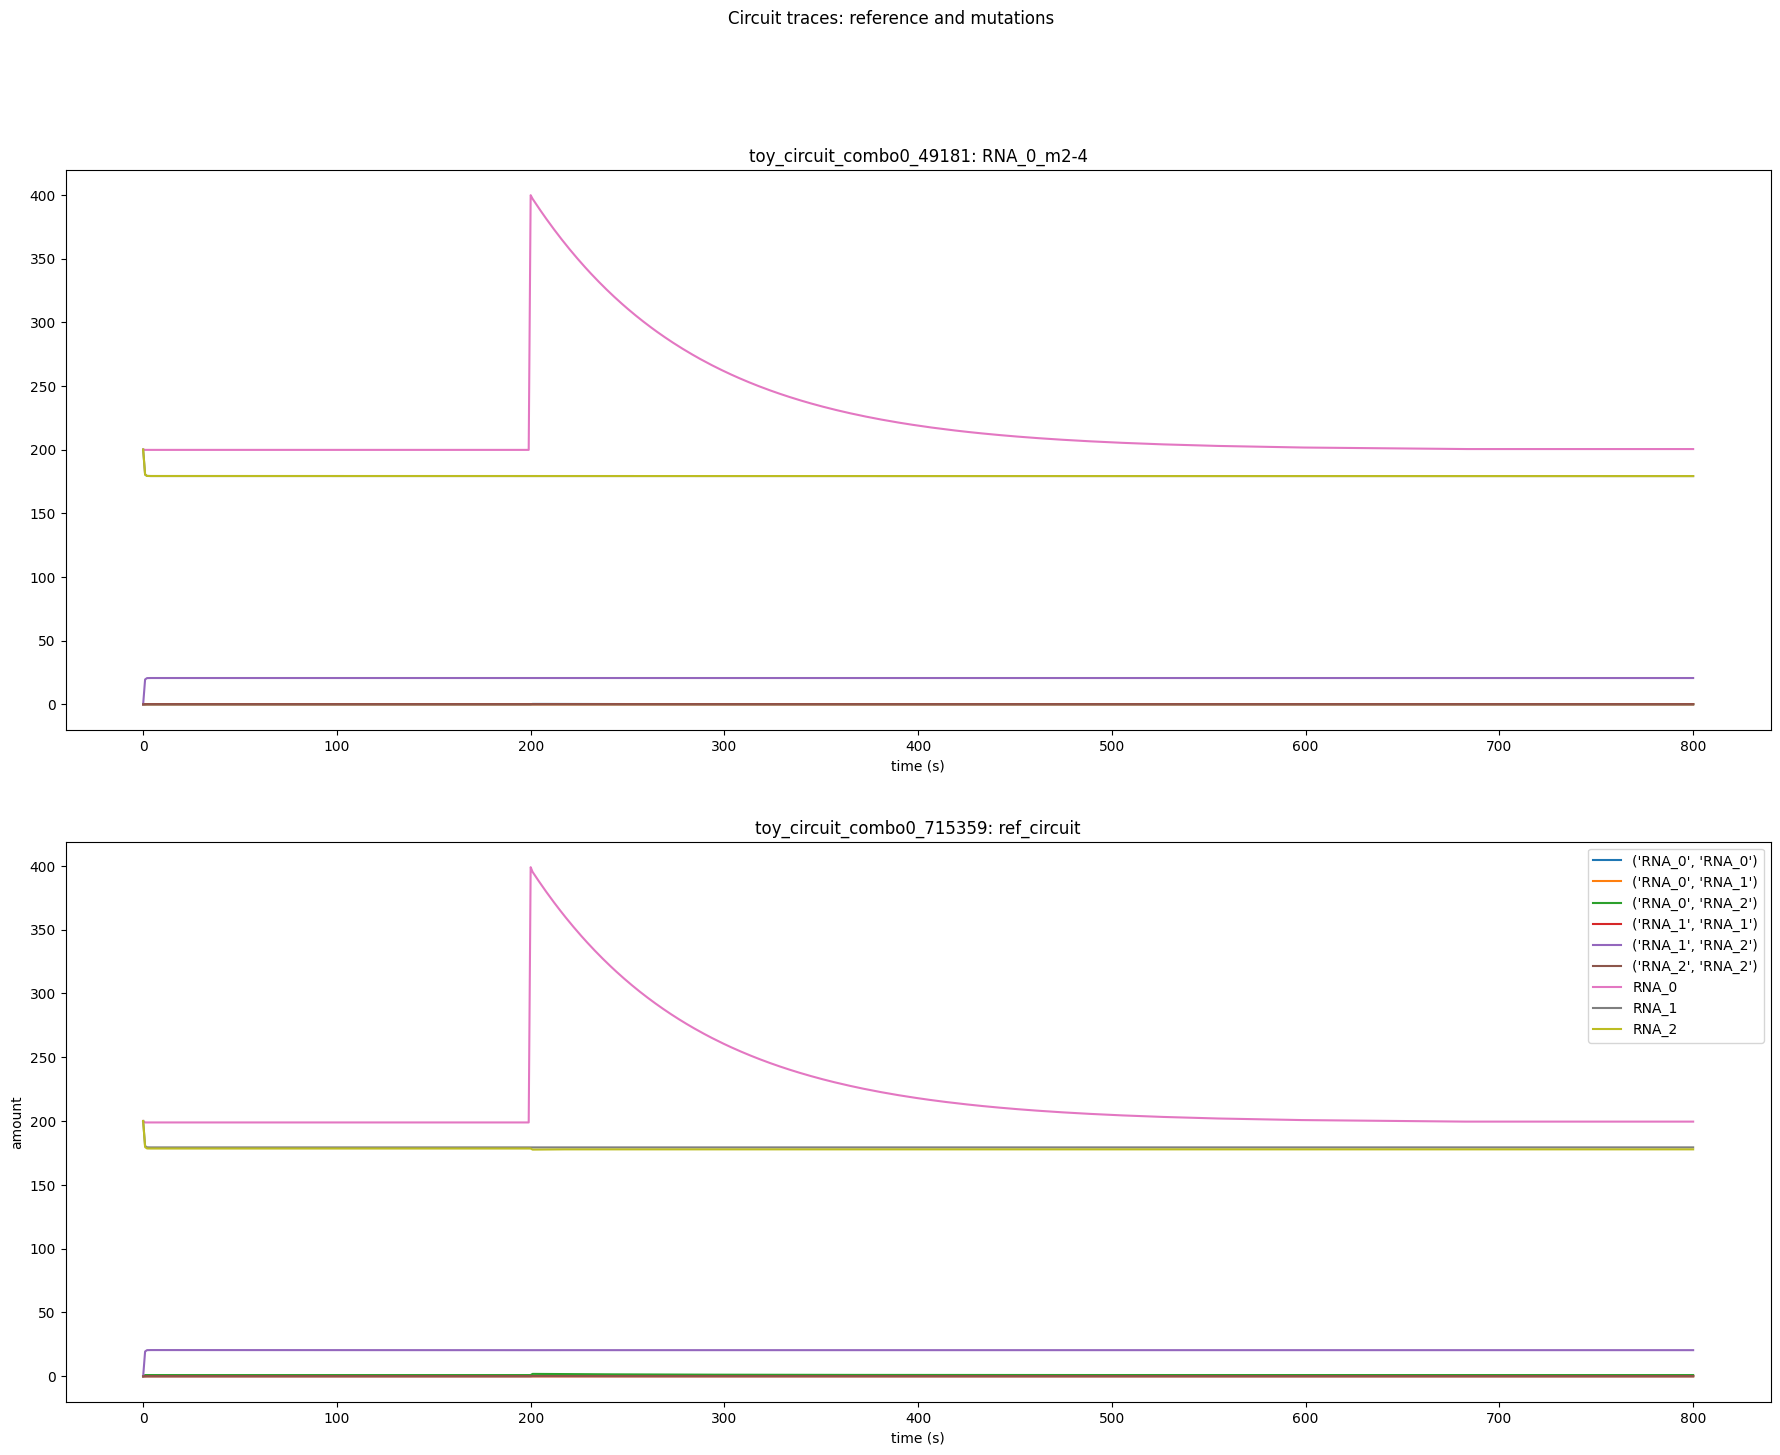

In [63]:
circuits = [circuits1[1], circuits2[1]]
num_circuits = len(circuits)
nm=0
plt.figure(figsize=(22, 16))
for i in range(len(circuits)):
    ax = plt.subplot(num_circuits,nm+1,i+1)
    plt.plot(np.concatenate([tss, tyy + tss[-1]]), np.concatenate([b_copynumbers[i].T, b_new_copynumbers[i].T]))
    plt.title(f'{circuits[i].name}: {circuits[i].subname}')
    plt.xlabel('time (s)')
plt.legend([s.name for s in circuits[0].model.species], loc='upper right')
plt.ylabel('amount')

plt.suptitle('Circuit traces: reference and mutations')


In [68]:
sns.scatterplot(x=df['precision_wrt_species-6'], y=df['precision_wrt_species-6_ratio_from_mutation_to_base'], alpha=0.1)


KeyError: 'precision_wrt_species-6'

In [77]:
df = pd.DataFrame()
df[circ1_df.index] = circ1_df

In [81]:
circ1_df.to_frame()

,17669
circuit_name,toy_circuit_combo0_49181
mutation_num,2
sample_name,RNA_2
precision_wrt_species-6,528399.314401
precision_wrt_species-6_diff_to_base_circuit,525421.996496
precision_wrt_species-6_ratio_from_mutation_to_base,177.474284
sensitivity_wrt_species-6,0.000896
sensitivity_wrt_species-6_diff_to_base_circuit,0.00056
sensitivity_wrt_species-6_ratio_from_mutation_to_base,2.668261
